In [45]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=851aeaa9773fc7dc9a639b23df3169402100522a507703ab899bbad379767568
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [104]:
import os
import pandas as pd
import numpy as np
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
from pprint import pprint
from collections import  Counter
import seaborn as sns
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy import displacy


In [47]:
path = '/content/drive/My Drive/.../data/train_split'

print(os.listdir(path))

['test_10.csv', 'train_90.csv']


In [48]:
train = pd.read_csv(path + '/train_90.csv')
train.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,2203,"Honey, I made the news! Apparently that old la...",1,2.45,1.0,0.3
1,6150,What do you call Dracula's retarded cousin? Co...,1,2.10,0.0,2.5
2,7319,Researchers from Humboldt University in Berlin...,0,NaN,NaN,0.0
3,1096,Anal with my girlfriend made my whole day But ...,1,2.15,1.0,1.1
4,548,What do you say when your lesbian daughter bri...,1,2.15,1.0,2.4


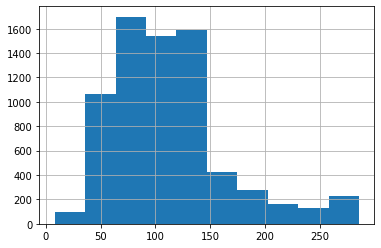

In [49]:
train['text'] = train['text'].str.lower()
#characters present in each sentence
train['text'].str.len().hist()

Observations: 
1. Sentences are 10-280 chars, mostly between 50-150

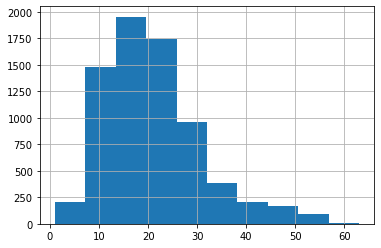

In [50]:
#the number of words in each input sentence
train['text'].str.split().map(lambda x: len(x)).hist()

Most have 10 to 25 words, range is 2 to 65.

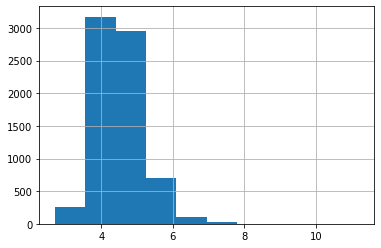

In [51]:
#average word length
train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [52]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 15 artists>

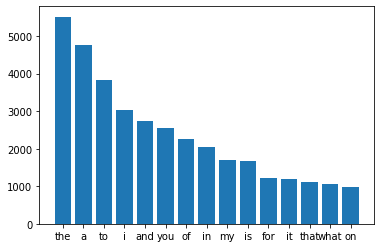

In [53]:
corpus=[]
new= train['text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

#pprint(dic)
   
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)


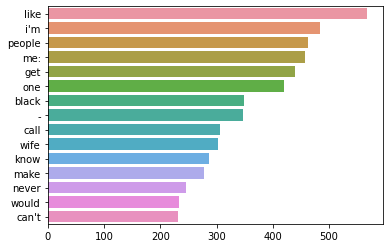

In [54]:
counter=Counter(corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:80]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [61]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


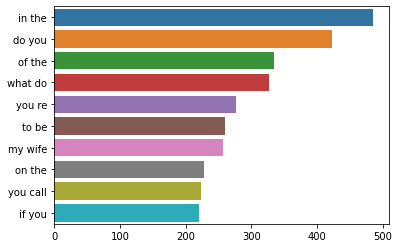

In [69]:
top_n_bigrams=get_top_ngram(train['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

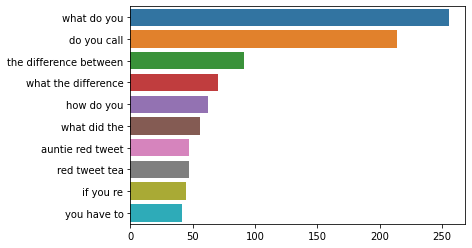

In [71]:
top_tri_grams=get_top_ngram(train['text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [72]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [78]:
def preprocess(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for joke in df['text']:
        words=[w for w in word_tokenize(joke) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess(train)

In [79]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

''' topic = 4
[(0,
  '0.014*"people" + 0.013*"n\'t" + 0.010*"like" + 0.009*"black" + 0.008*"love" + 0.007*"call" + 0.007*"..." + 0.006*"life" + 0.006*"need" + 0.005*"make"'),
 (1,
  '0.008*"time" + 0.008*"one" + 0.007*"n\'t" + 0.007*"wife" + 0.007*"like" + 0.005*"thing" + 0.005*"..." + 0.005*"day" + 0.004*"man" + 0.004*"get"'),
 (2,
  '0.010*"n\'t" + 0.009*"get" + 0.007*"one" + 0.007*"like" + 0.007*"say" + 0.006*"woman" + 0.006*"girl" + 0.006*"time" + 0.005*"\'re" + 0.005*"guy"'),
 (3,
  '0.023*"n\'t" + 0.012*"..." + 0.010*"said" + 0.009*"wife" + 0.009*"\'re" + 0.006*"get" + 0.005*"know" + 0.005*"say" + 0.005*"\'ve" + 0.005*"got"')]
'''
'''topic = 10

'''

In [84]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.036161  0.012344       1        1  12.737236
4     -0.026716  0.026858       2        1  12.538099
5     -0.053047 -0.019062       3        1  11.766357
8     -0.042668  0.065880       4        1  11.236743
3     -0.008102  0.007317       5        1   9.902909
0      0.004971 -0.045449       6        1   8.816443
9      0.037320  0.026110       7        1   8.774848
6     -0.060190  0.032649       8        1   8.693912
2      0.024388 -0.157014       9        1   8.433684
1      0.160205  0.050367      10        1   7.099770, topic_info=       Term         Freq        Total Category  logprob  loglift
7       n't  1077.000000  1077.000000  Default  30.0000  30.0000
363     one   434.000000   434.000000  Default  29.0000  29.0000
275     're   380.000000   380.000000  Default  28.0000  28.0000
62    black   319.000000   319.000000  Default  27.0000  27.0000
187  people   466.000000   466.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
81     life    16.696639   236.099027  Topic10  -5.8100  -0.0039
135    make    17.399711   298.544388  Topic10  -5.7687  -0.1974
198     'll    15.426770   193.117963  Topic10  -5.8891   0.1179
142     get    15.698211   428.430512  Topic10  -5.8716  -0.6615
62    black    15.362706   319.992790  Topic10  -5.8932  -0.3912

[859 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
11827      3  0.637832      'body
198        1  0.067316        'll
198        2  0.201949        'll
198        3  0.119098        'll
198        4  0.129455        'll
...      ...       ...        ...
970        6  0.049670      young
970       10  0.198680      young
6880       4  0.258966    youtube
6880       8  0.647414    youtube
7433       9  0.816820  zookeeper

[2435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 9, 4, 1, 10, 7, 3, 2])

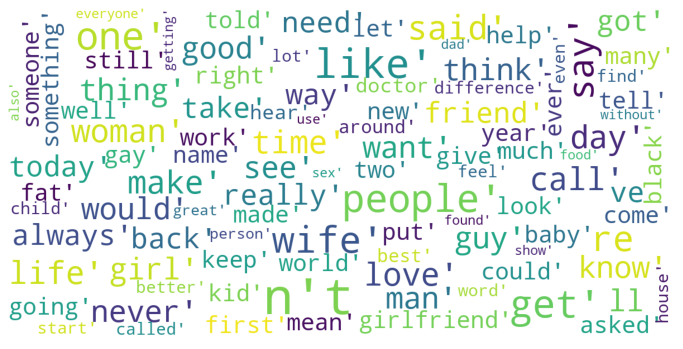

In [86]:
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(corpus)

In [88]:
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

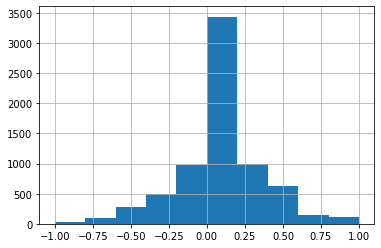

In [90]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
train['polarity_score']=train['text'].\
   apply(lambda x : polarity(x))

train['polarity_score'].hist()

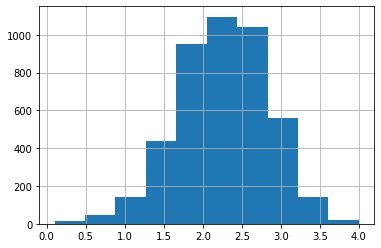

In [94]:
#train['is_humor'].hist()
train['humor_rating'].hist()

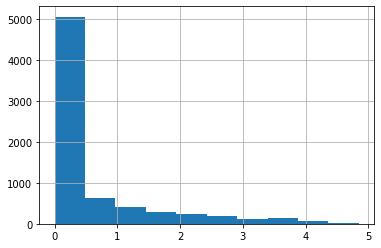

In [95]:
#train['humor_controversy'].hist()
train['offense_rating'].hist()

<BarContainer object of 3 artists>

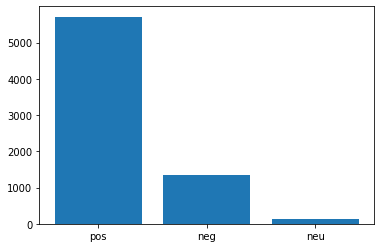

In [99]:
def humour(x):
    if x<2:
        return 'neg'
    elif x==2:
        return 'neu'
    else:
        return 'pos'
    
train['humour_polarity']=train['humor_rating'].\
   map(lambda x: humour(x))
plt.bar(train.humour_polarity.value_counts().index,
        train.humour_polarity.value_counts())

<BarContainer object of 3 artists>

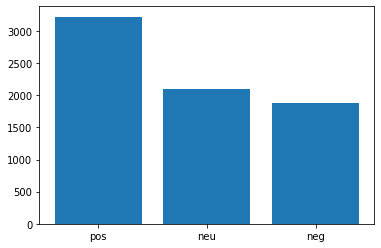

In [96]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
train['polarity']=train['polarity_score'].\
   map(lambda x: sentiment(x))
plt.bar(train.polarity.value_counts().index,
        train.polarity.value_counts())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

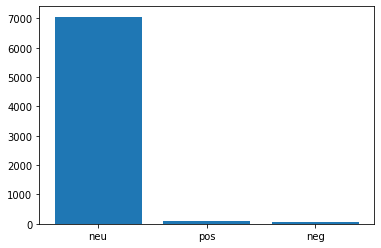

In [102]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])


train['polarity']=train['text'].\
    map(lambda x: get_vader_score(x))
polarity=train['polarity'].replace({0:'neg',1:'neu',2:'pos'})
plt.bar(polarity.value_counts().index,
        polarity.value_counts())

In [105]:
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=train['text'].\
    apply(lambda x : ner(x))

ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

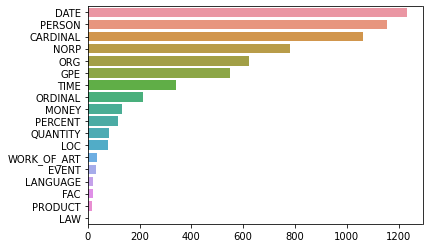

In [106]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


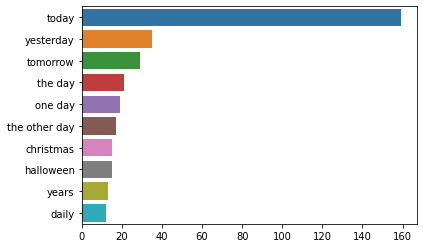

In [110]:
def ner(text,ent="DATE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

date=train['text'].apply(lambda x: ner(x))
date=[i for x in date for i in x]


counter=Counter(date)
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


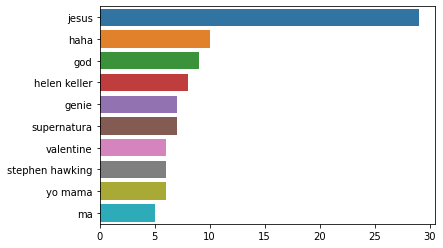

In [111]:
person=train['text'].apply(lambda x: ner(x,"PERSON"))
person=[i for x in person for i in x]


counter=Counter(person)
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


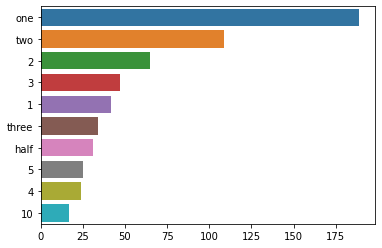

In [112]:
car=train['text'].apply(lambda x: ner(x,"CARDINAL"))
car=[i for x in car for i in x]


counter=Counter(car)
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


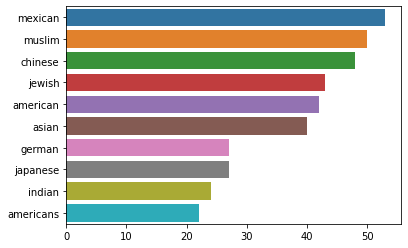

In [113]:
norp=train['text'].apply(lambda x: ner(x,"NORP"))
norp=[i for x in norp for i in x]


counter=Counter(norp)
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


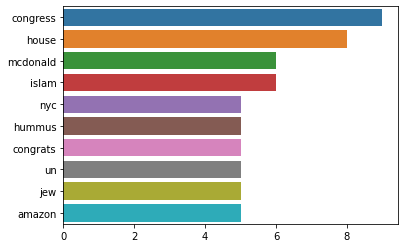

In [114]:
org=train['text'].apply(lambda x: ner(x,"ORG"))
org=[i for x in org for i in x]


counter=Counter(org)
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


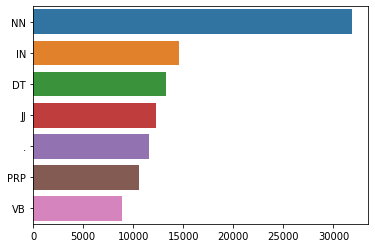

In [116]:
#pos tag struc
nltk.download('averaged_perceptron_tagger')

def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags=train['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]

counter=Counter(tags)
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

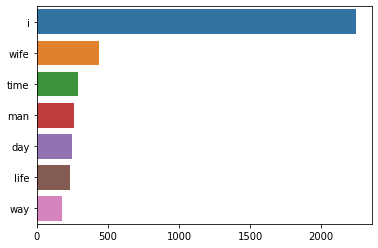

In [117]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj

words=train['text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]

counter=Counter(words)
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

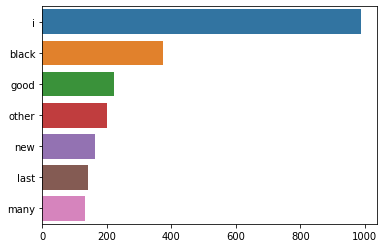

In [121]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='JJ': #IN
            adj.append(word)
    return adj

words=train['text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]

counter=Counter(words)
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)